#**5장. 합성곱 신경망 I**

###합성곱 신경망 맛보기

#####**라이브러리 호출**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

#####**CPU 혹은 GPU 장치 확인**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # GPU를 사용할 수 없기 때문에 cpu로 사용하도록 설정하였습니다.

#####**fashion_mnist 데이터셋 내려받기**

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                 train=False, transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:01<00:00, 17224542.44it/s]


Extracting ../chap05/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../chap05/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 308473.10it/s]


Extracting ../chap05/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../chap05/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5447990.51it/s]


Extracting ../chap05/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../chap05/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4630554.79it/s]

Extracting ../chap05/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../chap05/data/FashionMNIST/raw



#####**fashion_mnist 데이터를 데이터로더에 전달**

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100) # 데이터를 100개 단위로 불러오도록 지정
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

#####**분류에 사용될 클래스 정의**

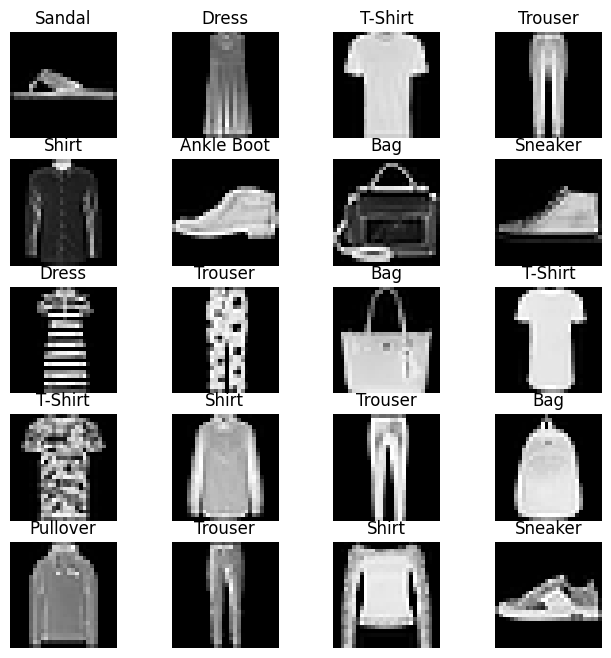

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat',
              5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}
  
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows + 1): # 20회 반복
  img_xy = np.random.randint(len(train_dataset)); # 0부터 train_dataset 길이 사이에서 랜덤한 수를 생성
  img = train_dataset[img_xy][0][0,:,:] # train_dataset의 [img_xy][0][0,:,:]에 해당하는 요소 값을 가져오기
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show() # 따라서 랜덤 이미지 20개를 출력해준다

#####**심층 신경망 모델 생성**

In [ ]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256) # 입력 784개, 출력 256개의 층 생성
    self.drop = nn.Dropout(0.25) # 0.25의 확률로 0이되고, 나머지 0.75는 (1/0.25)만큼 커지게 하기
    self.fc2 = nn.Linear(in_features=256, out_features=128) # 입력 256개, 출력 128개의 층 생성
    self.fc3 = nn.Linear(in_features=128, out_features=10) # 입력 128개, 출력 10개의 층 생성

  def forward(self, input_data): # 학습 데이터를 입력받아 순전파 학습을 진행시킨다. 이름 변경은 불가
    out = input_data.view(-1, 784) # view를 이용해 입력 데이터를 2차원 (n, 784)크기의 텐서로 변경. (-1, 784)를 지정했으므로 n은 파이토치가 결정
    out = F.relu(self.fc1(out)) # 활성화함수로 relu를 이용
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

#####**심층 신경망에서 필요한 파라미터 정의**

In [ ]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate); # 학습률을 0.001로 하고, 경사 하강법으로 Adam 사용
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


#####**심층 신경망을 이용한 모델 학습**

In [ ]:
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs): # epoch 만큼 반복
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device) # 모델과 처리할 데이터는 동일 장치에 있어야 함
    train = Variable(images.view(100, 1, 28, 28)) # Autograd가 Variable을 이용해 자동 미분을 수행
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50): 
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28)) # view를 사용해 1차원 텐서로 변환
        
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device) # 가장 높은 값을 가진 예측 가져오기
        predictions_list.append(predictions)
        correct += (predictions == labels).sum() # 정확도 계산
        total += len(labels)
    
      accuracy = correct * 100 / total # 50번 반복 이후 정확도 계산
      loss_list.append(loss.data) # 손실, 반복횟수, 정확도 저장
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy)) # 500회 반복마다 수치 출력

Iteration: 500, Loss: 0.6206870079040527, Accuracy: 83.6500015258789%
Iteration: 1000, Loss: 0.47731223702430725, Accuracy: 84.61000061035156%
Iteration: 1500, Loss: 0.39207541942596436, Accuracy: 84.63999938964844%
Iteration: 2000, Loss: 0.38639700412750244, Accuracy: 85.58999633789062%
Iteration: 2500, Loss: 0.3013065755367279, Accuracy: 86.11000061035156%
Iteration: 3000, Loss: 0.33872824907302856, Accuracy: 86.56999969482422%


#####**합성곱 네트워크 생성**

In [ ]:
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential( # 층을 차례로 쌓기 위해 Sequential을 사용
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1), # 입력 채녈 1개, 출력 채널 32개, 커널은 3x3 사각형, 패딩을 1로 준 합성곱 층
        nn.BatchNorm2d(32), # 합성곱 층을 지나면 배치 정규화, ReLU함수, 최대 풀링을 순서대로 진행
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential( # 수치를 변경시킨 합성곱 층을 하나 더 생성
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )

    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600) # 입력 64*6*6개, 출력 600개의 층 생성
    self.drop = nn.Dropout2d(0.25) # 0.25의 확률로 dropout 수행
    self.fc2 = nn.Linear(in_features=600, out_features=120) # 입력 600개, 출력 120개의 층 생성
    self.fc3 = nn.Linear(in_features=120, out_features=10) # 입력 120개, 출력 10개의 층 생성

  def forward(self, x): # 순전파 학습 진행
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1) # 행의 개수는 알지만 열의 개수를 알지 못해 -1로 지정, view를 통해 1차원 텐서로 변경
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

#####**합성곱 네트워크를 위한 파라미터 정의**

In [ ]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate); # 학습률을 0.001로 하고, 경사 하강법으로 Adam 사용
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


#####**모델 학습 및 성능 평가**

In [ ]:
num_epochs = 5 # 동일 코드여서 주석 생략하였습니다. 다만 시간 소요가 전보다 훨씬 많았습니다. 정확도도 물론 더 높았습니다.
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0

      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.45980918407440186, Accuracy: 87.80000305175781%
Iteration: 1000, Loss: 0.28020596504211426, Accuracy: 88.41999816894531%
Iteration: 1500, Loss: 0.28997913002967834, Accuracy: 87.16999816894531%
Iteration: 2000, Loss: 0.18763451278209686, Accuracy: 89.2300033569336%
Iteration: 2500, Loss: 0.1416349560022354, Accuracy: 89.38999938964844%
Iteration: 3000, Loss: 0.18458648025989532, Accuracy: 90.33000183105469%


###전이 학습 >> 이쪽 코드는 데이터셋 문제로 실습은 하지 못했습니다

#####**라이브러리 호출**

In [ ]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

#####**이미지 데이터 전처리 방법 정의**

In [ ]:
data_path = '../chap05/data/catanddog/train'

transform = transforms.Compose( # 이미지를 입력 데이터로 사용할 수 있도록 변환
                [
                    transforms.Resize([256, 256]), # 이미지를 256 x 256 사이즈로 조정
                    transforms.RandomResizedCrop(224), # 이미지를 랜덤으로 224 x 224 사이즈로 자른 뒤 다시 256 x 256 사이즈로 조정
                    transforms.RandomHorizontalFlip(), # 이미지에 랜덤으로 수평 뒤집기 수행
                    transforms.ToTensor() # 이미지를 텐서로 변환
])
train_dataset = torchvision.datasets.ImageFolder( # 해당 경로의 이미지에 위에서 정의한 전처리 수행
                data_path,
                transform=transform
)
train_loader = torch.utils.data.DataLoader( # 한번에 32만큼의 데이터를 8개 프로세스를 사용하여 무작위로 데이터 로더에 할당 
               train_dataset,
               batch_size=32,
               num_workers=8,
               shuffle=True
)

print(len(train_dataset))

FileNotFoundError: ignored

#####**학습에 사용될 이미지 출력**

In [ ]:
samples, labels = iter(train_loader).next() # samples, labels를 데이터 로더에서 순서대로 꺼내기
classes = {0:'cat', 1:'dog'}
flg = plt.figure(figsize=(16,24))
for i in range(24):
  a = fig.add_subplot(4,6,i+1)
  a.set_title(classes[labels[i].item()])
  a.axis('off')
  a.imshow(np.transpose(samples[i].numpy(), (1,2,0))) # 전치행렬을 취함
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

SyntaxError: ignored

#####**사전 훈련된 모델 내려받기**

In [ ]:
resnet18 = models.resnet18(pretrained=True) # 18개의 합성곱층으로 이루어진 합성곱 신경망

#####**사전 훈련된 모델의 파라미터 학습 유무 지정**

In [ ]:
def set_parameter_requires_grad(model, feature_extracting=True):
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False # 가중치를 고정하도록 지정하여 모델 일부를 고정하고 나머지를 학습

set_parameter_requires_grad(resnet18)

#####**ResNet18에 완전연결층 추가**

In [ ]:
resnet18.fc = nn.Linear(512, 2)

NameError: ignored

#####**모델의 파라미터 값 확인**

In [ ]:
for name, param in resnet18.named_parameters(): # 모델에 접근하여 파라미터를 가져오고, 출력
  if param.requires_grad:
    print(name, param.data)

#####**모델 객체 생성 및 손실 함수 정의**

In [ ]:
model = model.resnet18(pretrained=True)

for param in model.parameters():
  param.requires_grad = False # 가중치 고정

model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters(): # 완전 연결층은 가중치 고정 X
  param.requires.grad = True

optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()
print(model)

#####**모델 학습을 위한 함수 생성**

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13,
                is_train=True):
  since = time.time()
  acc_history = []
  loss_history = []
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      model.to(device)
      optimizer.zero_grad() # 기울기를 0으로 설정
      outputs = model(inputs)
      loss = criterion(outputs, labels) # criterion을 이용한 손실 계산
      _, preds = torch.max(outputs, 1) # 예측값이 가장 큰 것을 preds에 저장
      loss.backward() # 역전파 수행
      optimizer.step() # 가중치 업데이트

      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders.dataset)
    epoch_acc = running_corrects.double() / len(dataloaders.dataset)
    print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    if epoch_acc > best_acc: # 가장 높은 정확도 갱신
      best_acc = epoch_acc

    acc_history.append(epoch_acc.item())

        loss_history.append(epoch_loss)
        torch.save(model.state_dict(), as path.join('../chap05/data/catanddog/',
                                                    '{0:0=2d}.pth'.format(epoch)))
        print()

      time_elapsed = time.time() - since
      print('Training complete in {:.0f}m {:0f}s'.format(time_elapsed // 60,
                                                         time_elapsed % 60))
      print('Best Acc: {:4f}'.format(best_acc))
      return acc_history, loss_history

#####**파라미터 학습 결과를 옵티마이저에 전달**

In [ ]:
params_to_update = []
for name, param in resnet18.named_parameters():
  if param.requires_grad == True:
    params_to_update.append(param) # requires_grad == True인 학습 결과만 리스트에 저장
    print("\t", name)

optimizer = optim.Adam(params_to_update) # 생성된 리스트를 Adam 대상으로 지정

#####**모델 학습**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion,
                                              optimizer, device)

#####**테스트 데이터 호출 및 전처리**

In [ ]:
test_path = '../chap05/data/catanddog/test'

transform = transforms.Compose( # 224 x 224 사이즈로 변경 후 텐서 변환
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)

test_loader = torch.utils.data.DataLoader( # 해당 속성값들로 데이터 로드
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))

#####**테스트 데이터 평가 함수 생성**

In [ ]:
def eval_model(model, dataloadeers, device):
  since = time.time()
  acc_history = []
  best_acc = 0.0

  saved_models = glob.glob('../chap05/data/catanddog/' + '*.pth') # 원하는 파일만 추출
  saved_models.sort()
  print('saved_model', saved_models)

  for model_path in saved_models:
    print('Loading model', model_path)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(device)
    running_corrects = 0

    for inputs, labels in dataloaders:
      inputs = inputs.to(device)
      labels = labels.to(device)

      with torch.no_grad(): # 그래디언트 계산을 수행하지 않도록 설정
        outputs = model(inputs)

      _, preds = torch.max(outputs.data, 1) # 배열의 최댓값을 저장
      preds[preds >= 0.5] = 1 # preds이 0.5보다 크면 참
      preds[preds < 0.5] = 0 # preds가 0.5보다 작으면 거짓
      running_corrects += preds.eq(labels.cpu()).int().sum()
      
      epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 정확도 계산
      print('Acc: {:4f}'.format(epoch_acc))

      if epoch_acc > best_acc: # 최고의 정확도 갱신
        best_acc = epoch_acc

        acc_history.append(epoch_acc.item())
        print()

      time_elapsed = time.time() - since
      print('Validation complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                            time_elapsed % 60))
      print('Best Acc: {:4f}'.format(best_acc))

      return acc_history

#####**테스트 데이터를 평가 함수에 적용**

In [ ]:
val_acc_hist = eval_model(resnet18, test_loader, device)

#####**훈련과 테스트 데이터의 정확도를 그래프로 확인**

In [ ]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

#####**훈련 데이터의 오차에 대한 그래프 확인**

In [ ]:
plt.plot(train_loss_hist)
plt.show()

#####**예측 이미지 출력을 위한 전처리 함수**

In [ ]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy() # 텐서를 복사해 생성하지만, 기울기에는 영향을 주지 않음
  image = image.transpose(1, 2, 0) # 이미지 차원 변환
  image = image * (np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))) # 이미지 조절
  image = image.clip(0, 1) # 이미지 데이터를 0과 1사이로 제한
  return image

#####**개와 고양이 예측 결과 출력**

In [ ]:
classes = {0:'cat', 1:'dog'} # 대부분의 코드가 겹쳐서 주석은 중복 작성하지 않았습니다.

dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)

flg = plt.figure(figsize=(25,4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_conveert(images[idx]))
  a.set_title(classes[labels[i].item()])
ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].
                                                                          item()])), color=("green" if preds[idx]==labels[idx] else "red"))
plt.show()
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)

###설명 가능한 CNN

#####**필요한 라이브러리 호출**

In [14]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#####**설명 가능한 네트워크 생성**

In [20]:
class XAI(torch.nn.Module): 
  def __init__(self, num_classes=2):
    super(XAI, self).__init__()
    self.features = nn.Sequential( # 합성곱 층을 쌓는 과정
        nn.Conv2d(3, 64, kernel_size=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True), # 기존 데이터를 연산의 결괏값으로 대체
        nn.Dropout(0.3),
        nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.classifier = nn.Sequential(
        nn.Linear(512, 512, bias=False), # 입력 512, 출력 512의 완전 연결층
        nn.Dropout(0.5), # 0.5 비율로 dropout 수행
        nn.BatchNorm1d(512), # 입력이 512인 배치 정규화 층 추가
        nn.ReLU(inplace=True), # 기존 데이터를 연산의 결괏값으로 대체
        nn.Dropout(0.5), # 0.5 비율로 dropout 수행
        nn.Linear(512, num_classes) # 입력 512, 출력 num_classes인 완전 연결층
    )

  def forward(self, x): # 순전파 학습
    x = self.features(x)
    x = x.view(-1, 512) # 차원 변환
    x = self.classifier(x)
    return F.log_softmax(x)

#####**모델 객체화**

In [21]:
model = XAI() # 객체 생성
model.to(device)
model.eval() # 객체를 모델 평가에 사용

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

#####**특성 맵을 확인하기 위한 클래스 정의**

In [22]:
class LayerActivations:
  features = []
  def __init__(self, model, layer_num):
    self.hook = model[layer_num].register_forward_hook(self.hook_fn) # print 대신 hook을 사용해 각 계층의 활성화 함수 값 및 기울기 값 확인

  def hook_fn(self, module, input, output):
    self.features = output.detach().numpy() # 계층의 출력값을 features에 저장
  
  def remove(self):
    self.hook.remove() # hook 제거

#####**이미지 호출**

TypeError: ignored

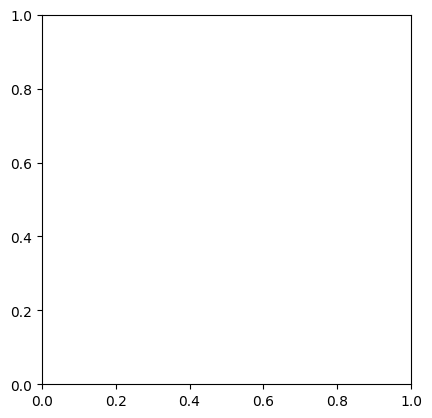

In [24]:
img = cv2.imread("../chap05/data/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100,100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0)
print(img.shape)

이미지가 또 불러와지지 않아 구현 부분까지만 코드 및 주석 작성하였습니다.